# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Star with Free Background

Load data.

In [3]:
nruns, nsizes, ntrials = 9, 5, 100000
sigclip = 5.

# true values
f, ferr, ftrials, imgsize = np.zeros((4, nruns, nsizes))

# extract data
flux, fluxerr, x, y, b = np.zeros((5, nruns, nsizes, ntrials))
for i in range(nruns):
    for j in range(nsizes):
        fname = 'data/flt_back/run{0}.fits'.format(i * nsizes + j)  # run
        if os.path.isfile(fname):
            hdul = fits.open(fname)
            # grab true values
            f[i, j] = hdul[0].header['TRUEFLUX']  # true flux
            psfwidth = hdul[0].header['PSFWIDTH']  # Gaussian PSF width
            noise = hdul[0].header['NOISE']  # iid Gaussian noise
            aeff = 4. * np.pi * psfwidth**2  # effective area
            imgsize[i, j] = hdul[0].header['IMGSIZE']  # image area
            ferr[i, j] = 1./np.sqrt(1./(aeff) - 1./(imgsize[i, j]**2))  # true error
            # grab trials
            data = hdul[1].data
            flux[i, j] = data['Flux']  # fluxes
            fluxerr[i, j] = data['Fluxerr']  # flux errors
            x[i, j], y[i, j] = data['X'], data['Y']  # positions
            b[i, j] = data['Back']
            # clip suspicious trials
            pos = np.c_[x[i, j], y[i, j]]
            cinv = np.linalg.inv(np.cov(pos, rowvar=False))  # inv-cov
            sqdist = np.array([np.dot(np.dot(p, cinv), p) 
                               for p in pos])  # normalized distance
            sel = (sqdist <= sigclip**2) & (flux[i, j] / fluxerr[i, j] > 0.2)  # clip outliers
            flux[i, j, ~sel], fluxerr[i, j, ~sel] = np.nan, np.nan
            x[i, j, ~sel], y[i, j, ~sel] = np.nan, np.nan
            b[i, j, ~sel] = np.nan
            ftrials[i, j] = len(sel)
        else:
            print(fname + ' not found.')

data/flt_back/run23.fits not found.
data/flt_back/run24.fits not found.
data/flt_back/run28.fits not found.
data/flt_back/run29.fits not found.
data/flt_back/run32.fits not found.
data/flt_back/run33.fits not found.
data/flt_back/run34.fits not found.
data/flt_back/run37.fits not found.
data/flt_back/run38.fits not found.
data/flt_back/run39.fits not found.
data/flt_back/run42.fits not found.
data/flt_back/run43.fits not found.
data/flt_back/run44.fits not found.


In [4]:
# define relevant quantities

snr = f / ferr  # true SNR
favg, fstd = np.nanmean(flux, axis=2), np.nanstd(flux, axis=2)
fbias_avg = (favg - f) / f  # fractional bias
fbias_err = fstd / f / np.sqrt(ftrials)  # uncertainty

flux_snr = flux / fluxerr  # measured SNR
flux_debias = flux * (1 - flux_snr**-2 - flux_snr**-4)  # de-biased flux (2nd order)
fdebias_avg = np.nanmean(flux_debias, axis=2)  # average
fdebias_std = np.nanstd(flux_debias, axis=2)  # scatter

# derive error via bootstrapping
nbootstrap = 250
np.random.seed(2764)  # declare seed
fdebias_std_err = np.array([[np.nanstd([np.nanstd(np.random.choice(flux_debias[j, k], 
                                                                  size=ntrials)) 
                                        for i in range(nbootstrap)])
                             for k in range(nsizes)]
                            for j in range(nruns)])  # error on scatter

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Plot bias vs SNR.

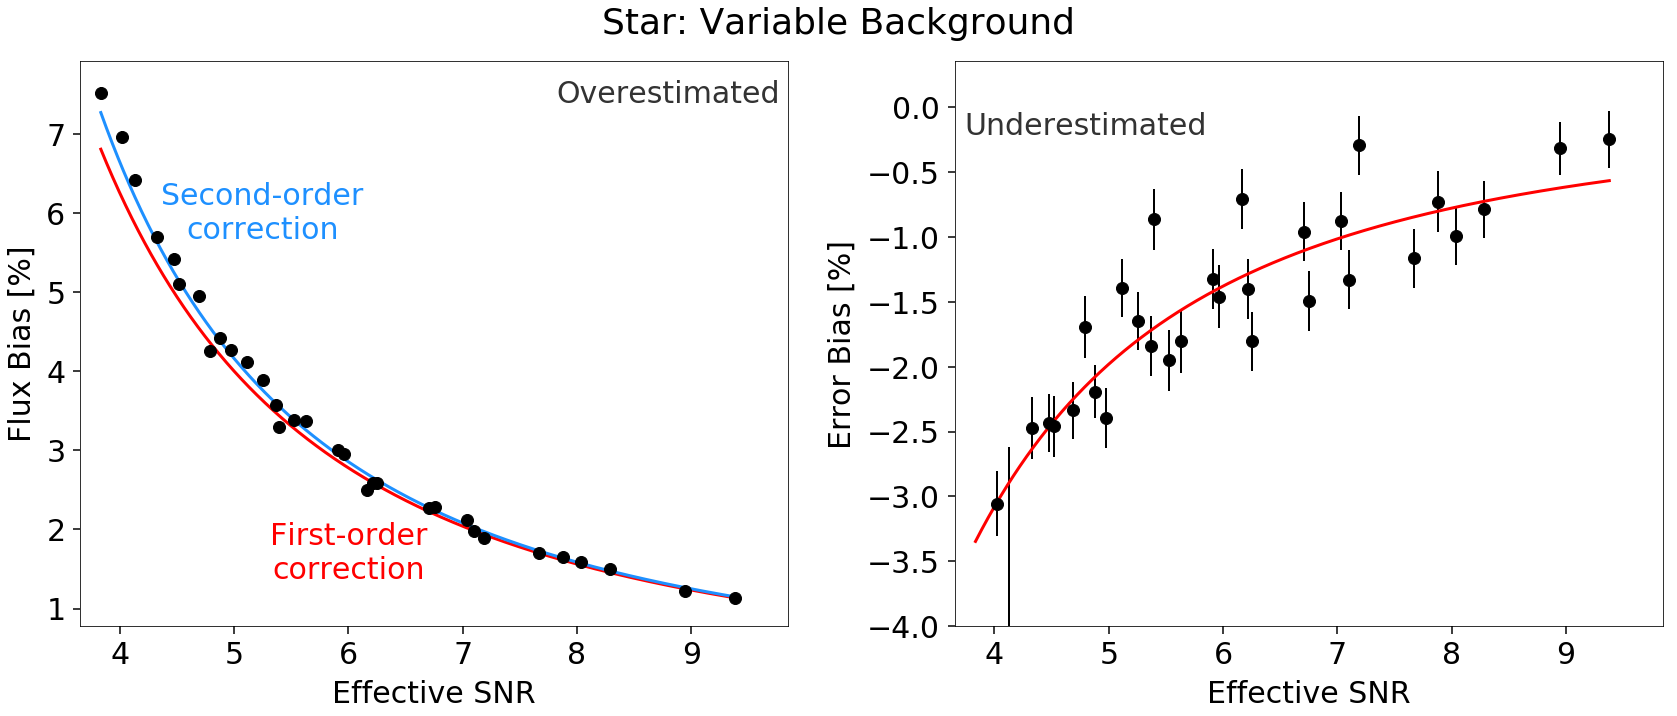

In [5]:
snr_grid = np.linspace(np.nanmin(snr), np.nanmax(snr), 1000)

# plot flux bias + variance
plt.figure(figsize=(24, 10))
plt.suptitle('Star: Variable Background', y=1.02)

# flux
plt.subplot(1, 2, 1)
plt.errorbar(snr.flatten(), fbias_avg.flatten() * 100., 
             yerr=fbias_err.flatten() * 100.,
             marker='o', color='black', 
             linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, snr_grid**-2 * 100., 
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (snr_grid**-2 + snr_grid**-4) * 100., 
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# label
plt.text(6, 1.7, 'First-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='red')
plt.text(5.25, 6, 'Second-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='dodgerblue')
# prettify
plt.text(8.8, 7.5, 'Overestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.xlabel(r'Effective SNR', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr) / 1.05, np.nanmax(snr) * 1.05)
plt.tight_layout()

# errors
plt.subplot(1, 2, 2)
plt.errorbar(snr.flatten(), (1. - fdebias_std / ferr).flatten() * 100., 
             yerr=(fdebias_std_err / ferr).flatten() * 100., marker='o', 
             color='black', linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional error bias
plt.plot(snr_grid, (1. - np.sqrt(1 + snr_grid**-2)) * 100., 
           linestyle='-', color='red', 
           label='1st-order', lw=3)  # 1st-order correction
# prettify
plt.text(4.8, -0.15, 'Underestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.xlabel(r'Effective SNR', labelpad=10)
plt.ylabel(r'Error Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr) / 1.05, np.nanmax(snr) * 1.05)
plt.ylim([-4, None])
plt.tight_layout()

# save figure
plt.savefig('plots/star_free_back.png', bbox_inches='tight')